
# Transformer Attention Project - KTH AI Society
**Main Goal:** Explain why **K**, **Q**, **V** are the core of attention and **visualize attention on a sentence**.

---

1. A concise theory recap of Queries, Keys, and Values with the scaled dot‑product attention formula.  
2. A minimal self‑attention implementation in PyTorch to cement understanding.  
3. A practical demo that extracts **real attention weights** from a pre‑trained BERT model.  
4. Clear **heatmaps** of attention across tokens and an interactive visualization with **BERTViz**.


## 0. Setup
Run the following cell to install dependencies if needed. If you are on Colab, this will pull packages. On a local machine, ensure you have Python 3.9+.


In [53]:

# If running on a clean environment, uncomment the lines below
%pip install --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
%pip install --quiet transformers matplotlib bertviz


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [54]:
import torch
print("torch:", torch.__version__)
x = torch.randn(2,3)
print("ok, tensor shape:", x.shape)

torch: 2.9.0
ok, tensor shape: torch.Size([2, 3])


## 1. Theory recap: Q, K, V and Scaled Dot-Product Attention

Let $X \in \mathbb{R}^{n \times d_{\text{model}}}$ be the matrix of token embeddings. We learn three linear projections

$$
Q = X W_Q,\quad K = X W_K,\quad V = X W_V,
$$

with $W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k}$.

**Intuition**
- A token forms a **Query** to ask the sequence for relevant information.
- Each token provides a **Key** describing what it contains.
- The **Value** carries the content that will be aggregated.

**Scaled dot-product attention**

$$
\text{Attention}(Q, K, V) \;=\; \text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)\, V
$$

- $QK^\top$ computes pairwise similarities between queries and keys.
- Division by $\sqrt{d_k}$ stabilizes gradients.
- `softmax` converts scores into attention weights that sum to 1 per query row.
- Multiplying by $V$ yields a **contextualized representation** for each token.

**Multi-head attention**

Multiple heads learn separate $W_Q, W_K, W_V$, each attending to different relations. Head outputs are concatenated and linearly projected to mix perspectives.


## 2. Minimal self‑attention in PyTorch
This block implements the **scaled dot‑product self‑attention** on synthetic embeddings. It is purely pedagogical.


In [55]:

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

class MiniSelfAttention(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)

    def forward(self, X):
        # X: (batch, seq_len, d_model)
        Q = self.W_q(X)  # (batch, seq, d)
        K = self.W_k(X)  # (batch, seq, d)
        V = self.W_v(X)  # (batch, seq, d)
        # Scores: (batch, seq, seq)
        scores = torch.matmul(Q, K.transpose(1, 2)) / math.sqrt(self.d_model)
        weights = F.softmax(scores, dim=-1)
        out = torch.matmul(weights, V)  # (batch, seq, d)
        return out, weights

# Demo on synthetic embeddings
batch, seq_len, d_model = 1, 6, 32
X = torch.randn(batch, seq_len, d_model)
att = MiniSelfAttention(d_model)
att_out, att_w = att(X)

print("Attention weights shape:", att_w.shape)  # (1, 6, 6)
print("Row sums (should be 1):", att_w[0].sum(dim=-1))


Attention weights shape: torch.Size([1, 6, 6])
Row sums (should be 1): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)



### Visualize the weight matrix with Matplotlib
We plot a heatmap for the synthetic example.


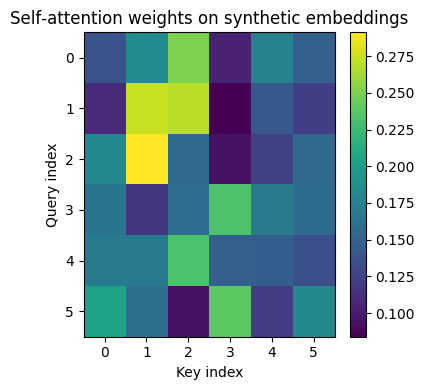

In [56]:

import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(att_w[0].detach().numpy(), aspect='auto', interpolation='nearest')
plt.colorbar()
plt.title("Self‑attention weights on synthetic embeddings")
plt.xlabel("Key index")
plt.ylabel("Query index")
plt.tight_layout()
plt.show()



## 3. Extract real attention from a pre‑trained Transformer (BERT)
We will use a pre‑trained **bert‑base‑uncased** from Hugging Face to get actual attention weights for a sentence.  


In [57]:

from transformers import AutoTokenizer, AutoModel

sentence = "The quick brown fox jumps over the lazy dog."
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased", output_attentions=True)

inputs = tokenizer(sentence, return_tensors="pt")
outputs = model(**inputs)
attentions = outputs.attentions 
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

print(f"Layers: {len(attentions)}")
print(f"Shape of one layer: {attentions[0].shape}  # (batch, heads, seq, seq)")
print("Tokens:", tokens)


Layers: 12
Shape of one layer: torch.Size([1, 12, 12, 12])  # (batch, heads, seq, seq)
Tokens: ['[CLS]', 'the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.', '[SEP]']



### Heatmap for a single head
We visualize **Layer 1, Head 1** attention. Rows are queries, columns are keys.


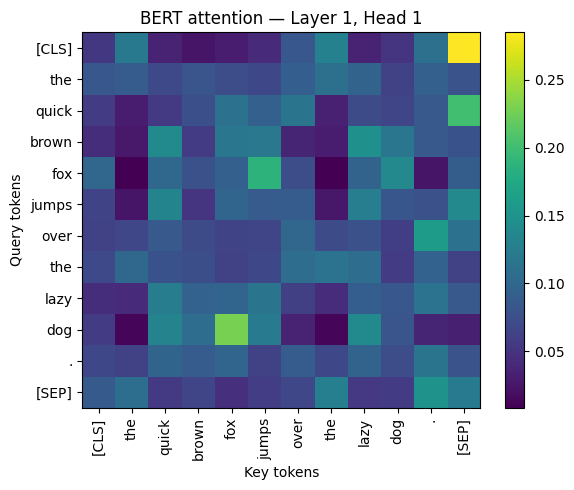

In [58]:

layer_idx = 0   # first layer
head_idx = 0    # first head

A = attentions[layer_idx][0, head_idx].detach().numpy()

plt.figure(figsize=(6, 5))
plt.imshow(A, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
plt.yticks(ticks=range(len(tokens)), labels=tokens)
plt.title("BERT attention — Layer 1, Head 1")
plt.xlabel("Key tokens")
plt.ylabel("Query tokens")
plt.tight_layout()
plt.show()



### Visualize all heads in a layer
The following loop will render one figure per head to respect the one‑plot‑per‑figure guideline.


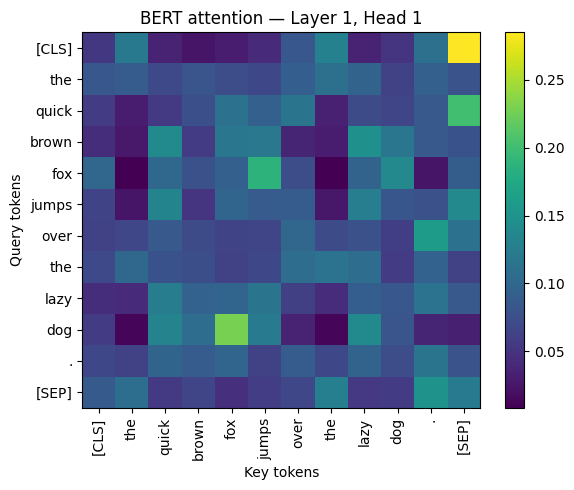

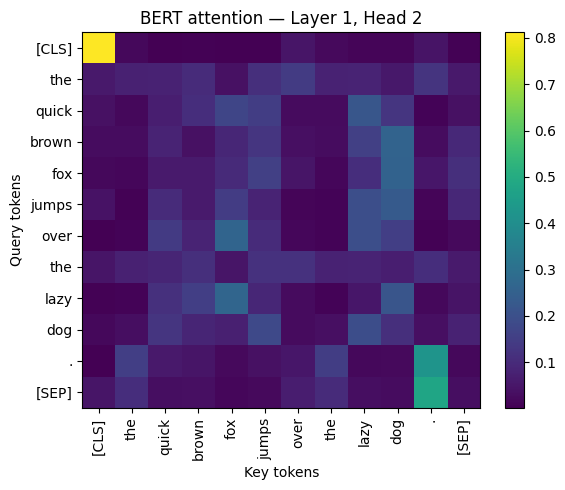

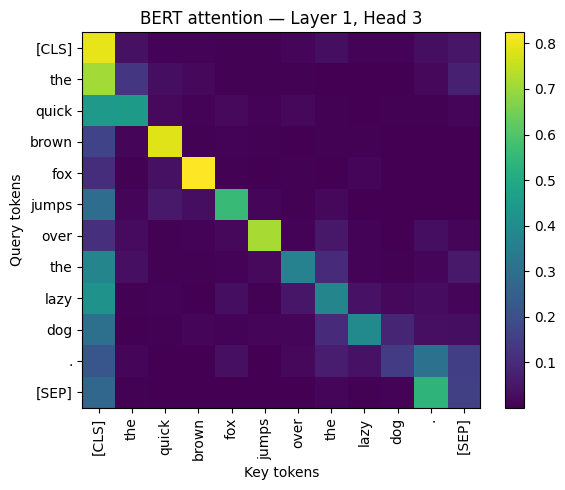

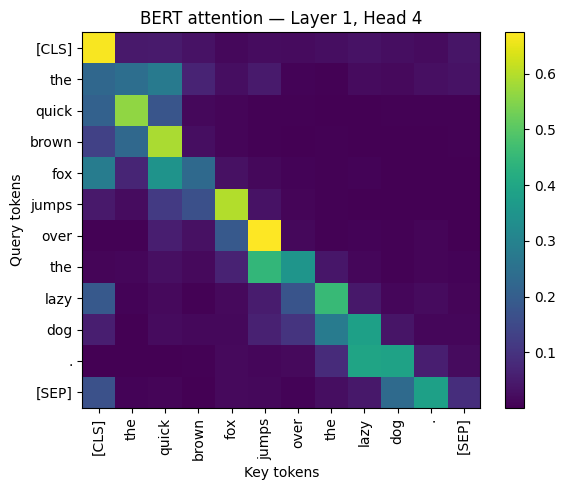

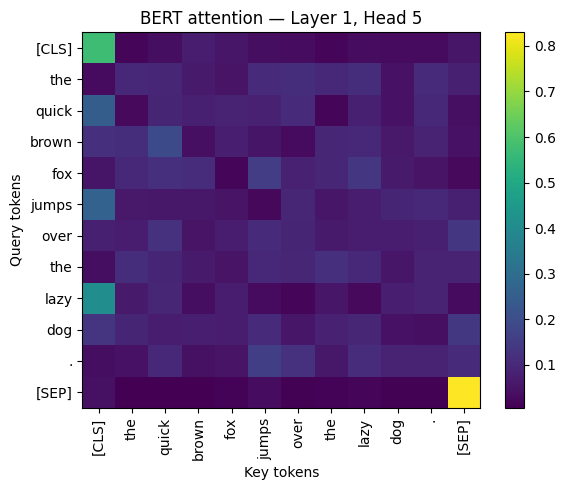

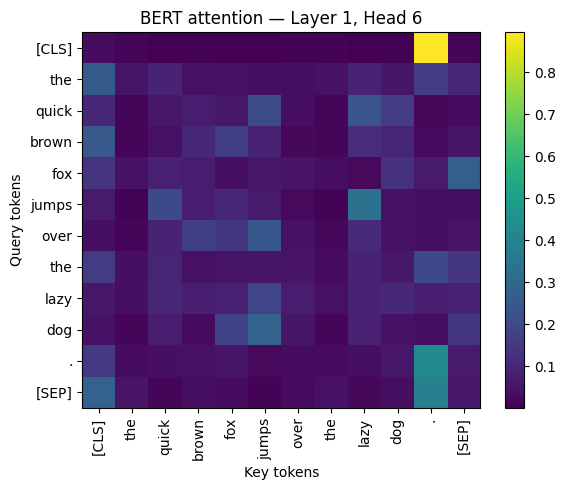

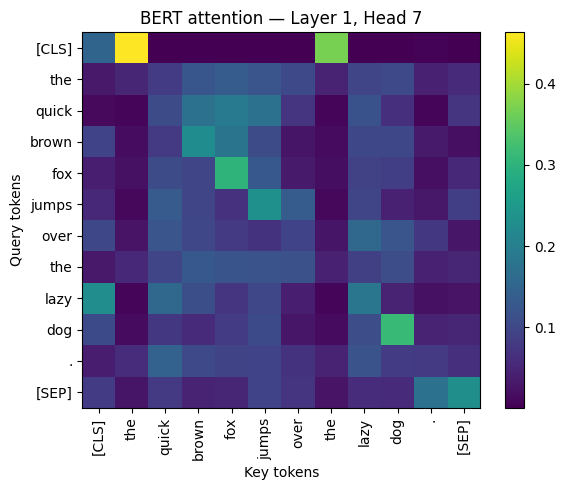

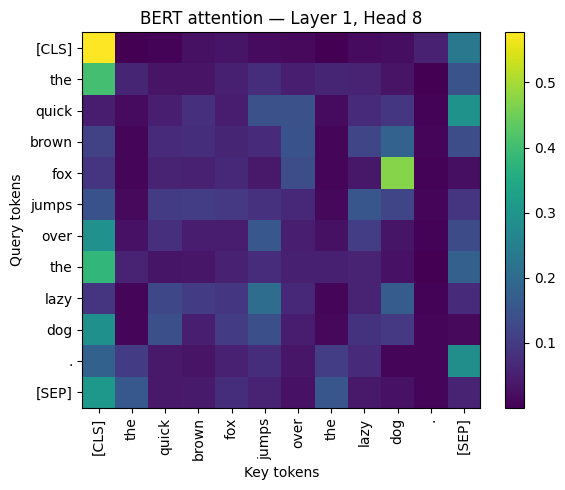

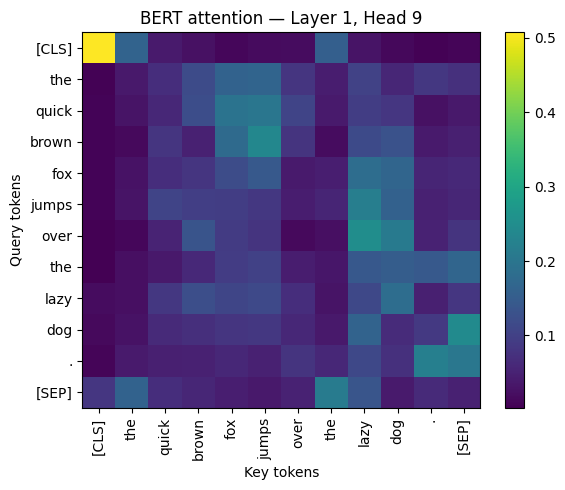

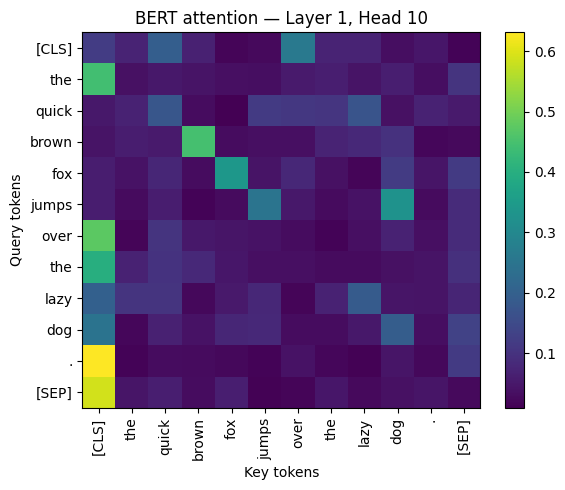

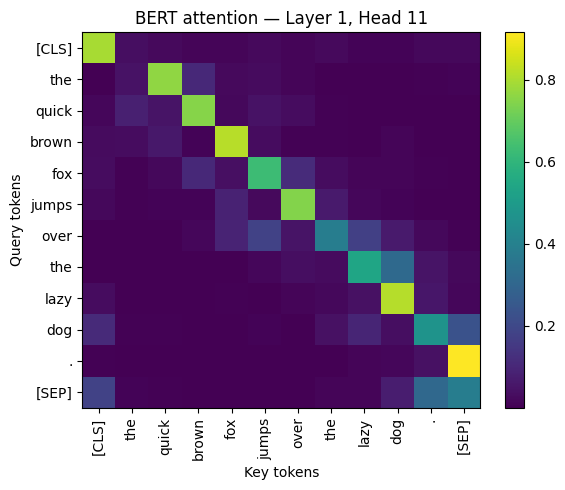

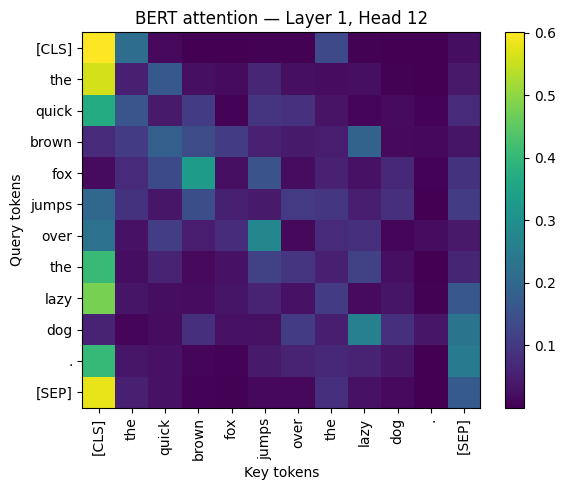

In [59]:

layer_idx = 0  # choose a layer to inspect
num_heads = attentions[layer_idx].shape[1]

for h in range(num_heads):
    A = attentions[layer_idx][0, h].detach().numpy()
    plt.figure(figsize=(6, 5))
    plt.imshow(A, aspect='auto', interpolation='nearest')
    plt.colorbar()
    plt.xticks(ticks=range(len(tokens)), labels=tokens, rotation=90)
    plt.yticks(ticks=range(len(tokens)), labels=tokens)
    plt.title(f"BERT attention — Layer {layer_idx+1}, Head {h+1}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.tight_layout()
    plt.show()



## 4. Interactive visualization with BERTViz
BERTViz provides an interactive **head view** similar to the one suggested.  

In [ ]:

from bertviz import head_view

head_view(attentions, tokens)


<IPython.core.display.Javascript object>


Notes
- Early layers often show localized or special‑token patterns.  
- Some heads emphasize CLS. Others track syntactic links like determiner → noun.  
- You may see **fox** attending to **dog**, indicating a semantic link in the example sentence.  
- The diversity across heads demonstrates why **multi‑head attention** helps model different relations.
